# Linear regression

We have now built up all of the knowledge necessary to do some **data analysis**. We're going to start with something that you're probably very familiar with: finding a **line of best fit**.

In all of the following examples, we will be dealing with **abstract** data (i.e. $x$ and $y$ rather than volume and pressure or time and concentration etc), so as to focus on the methodology behind what we are doing rather than the details of the data itself. There will be frequent references to various statistical concepts, but don't stress too much if you are unfamiliar with any of the terminology: **this is not a stats course**.

Let's imagine that we've been given some experimental data that is evidently linear:

In [1]:
%config InlineBackend.figure_format='retina'

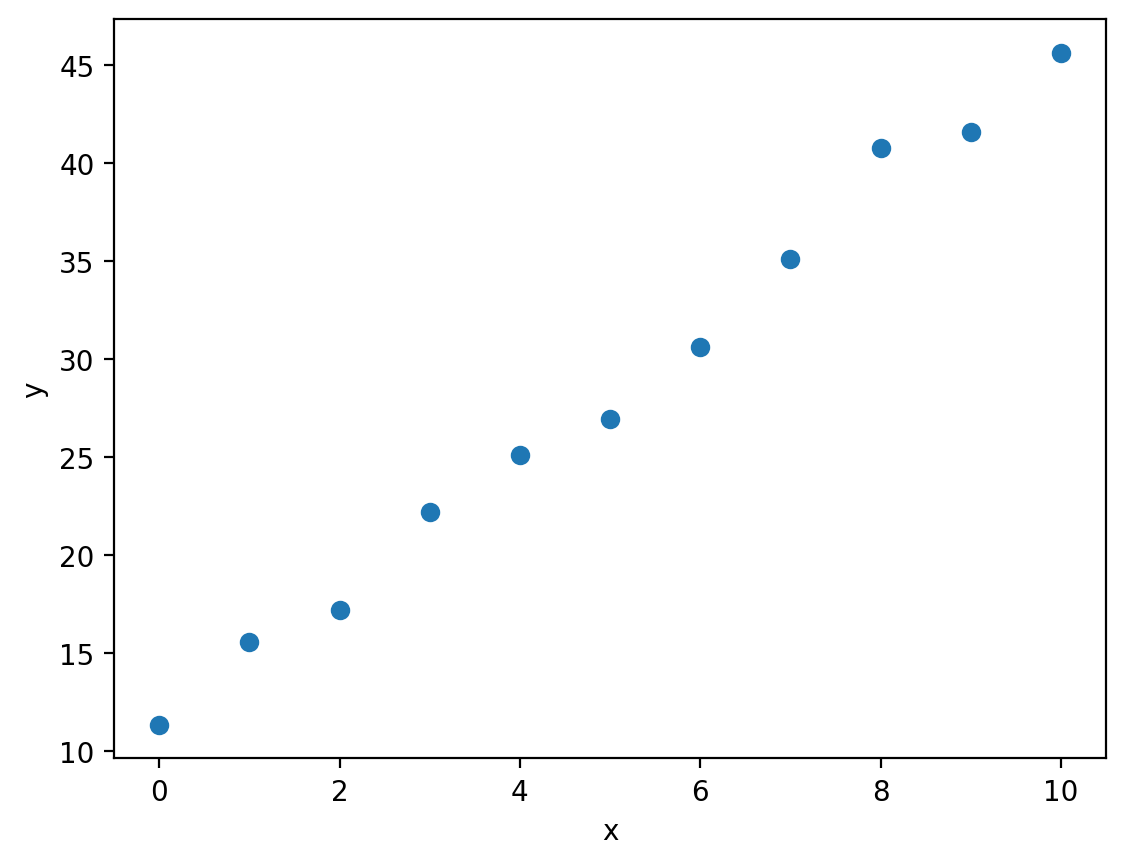

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.loadtxt('linear.csv', delimiter=',', unpack=True)

plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

You can download linear.csv [here](https://raw.githubusercontent.com/pythoninchemistry/ch12004/main/CH12004/lab_6/linear.csv).

In order to find a **line of best fit**, we would like to do [linear regression](https://en.wikipedia.org/wiki/Linear_regression). In short, we want to find the line:

$$y = mx + c,$$

(where $m$ is the slope and $c$ is the intercept), that is as close as possible to all the experimental data points. There are many ways to do linear regression in Python, but perhaps the simplest is the `linregress` function from the `scipy` library:

In [3]:
from scipy.stats import linregress

regression_data = linregress(x, y)

print(regression_data)

LinregressResult(slope=3.434454545454545, intercept=11.204090909090908, rvalue=0.9961041753472445, pvalue=8.369268779950266e-11, stderr=0.10134983826003473, intercept_stderr=0.5995937291506074)


The first thing you might notice about the code above is that the `import` statement looks a little different to those we have seen before. The `from` keyword allows to import individual functions or constants from a package rather than the whole thing. In this example, we have imported **just the linregress function**, which means we can **call** that function by typing `linregress(x, y)` rather than running `import scipy` and then having to type out `scipy.stats.linregress(x, y)`. To further clarify this, you may recall that we have made frequent use of `scipy` to access important physical constants such as $h$ and $k_{\mathrm{B}}$ by typing `scipy.constants.h` or `scipy.constants.k`. Using the `from` keyword, we could instead type:

In [4]:
from scipy.constants import h, k

print(h, k)

6.62607015e-34 1.380649e-23


Coming back to the rest of our linear regression code, we **called** the `linregress` functions with two arguments: `x` and `y`:

```python
regression_data = linregress(x, y)
```

These variables contain the experimental $x$ and $y$-data as plotted previously. We stored the output of the `linregress` function in a variable called `regression_data` and then passed this to the `print` function:

```python
print(regression_data)
```

The information **returned** from the `linregress` function contains the slope $m$ and the intercept $c$ of the line of best fit, alongside other useful information which we will discuss further shortly.

In [5]:
regression_data

LinregressResult(slope=3.434454545454545, intercept=11.204090909090908, rvalue=0.9961041753472445, pvalue=8.369268779950266e-11, stderr=0.10134983826003473, intercept_stderr=0.5995937291506074)

We can access the slope $m$ and the intercept $c$ as `regression_data.slope` and `regression_data.intercept` respectively:

In [6]:
print(f'm = {regression_data.slope}')
print(f'c = {regression_data.intercept}')

m = 3.434454545454545
c = 11.204090909090908


We now have all the information we need to construct and plot our **line of best fit**:

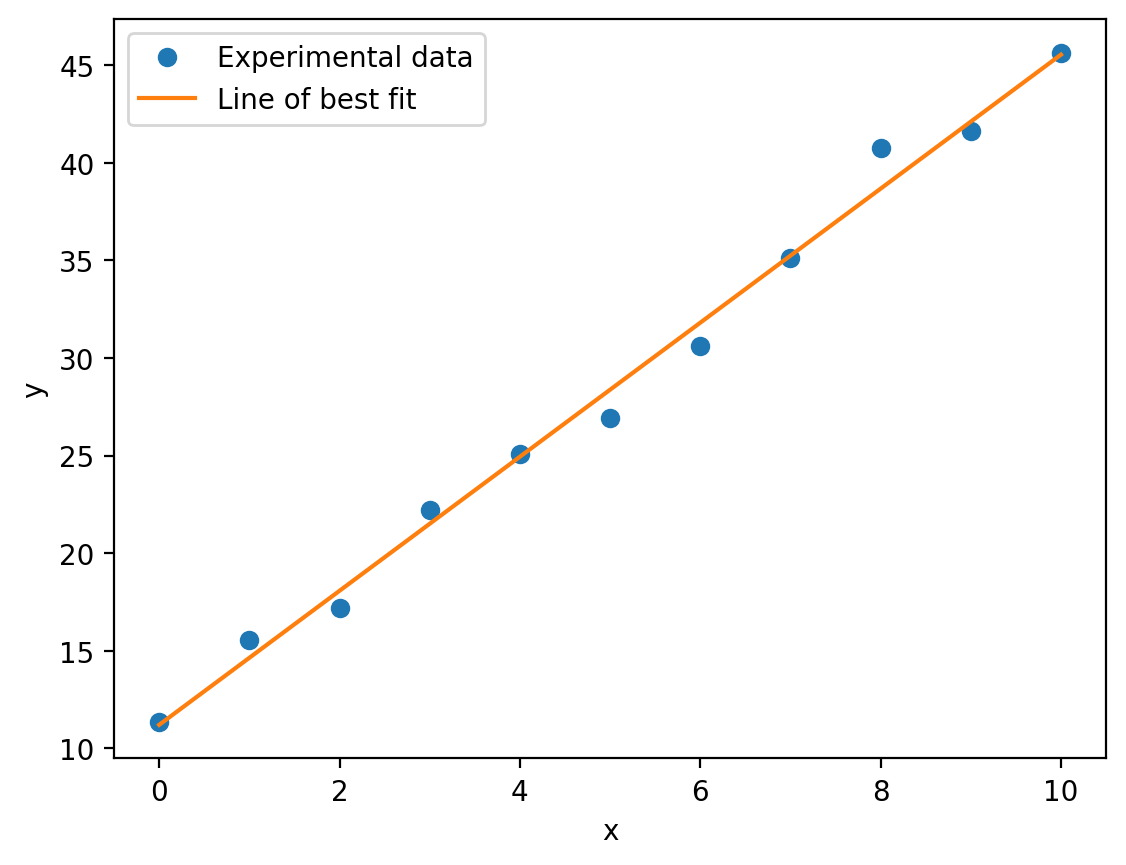

In [7]:
y_best_fit = regression_data.slope * x + regression_data.intercept # y = mx + c

plt.plot(x, y, 'o', label='Experimental data')
plt.plot(x, y_best_fit, label='Line of best fit')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.show()

It's worth emphasising at this stage that whilst the example is wholly abstract ($x$ and $y$ have no physical meaning and have no units), the same procedure could easily be applied to any linear dataset you might wish to analyse.

In addition to the slope and intercept of the line of best fit, the `linregress` function also gives us access to the [standard error](https://en.wikipedia.org/wiki/Standard_error) associated with both values via `regression_data.stderr` and `regression_data.intercept_stderr`:

In [8]:
print(f'm = {regression_data.slope} +/- {regression_data.stderr}')
print(f'c = {regression_data.intercept} +/- {regression_data.intercept_stderr}')

m = 3.434454545454545 +/- 0.10134983826003473
c = 11.204090909090908 +/- 0.5995937291506074


The `linregress` function uses the [ordinary least-squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) method to optimise $m$ and $c$, which assumes that the uncertainty (more specifically the [variance](https://en.wikipedia.org/wiki/Variance)) of all the experimental measurements are equal i.e. **all the error bars are the same size**. In the example we have worked through above, this assumption is valid (there are **no error bars** on our plot), but what if we want to account for data with some variance associated with each data point?

## Accounting for uncertainties

Let's add some uncertainty to the experimental $y$-data from our previous example:

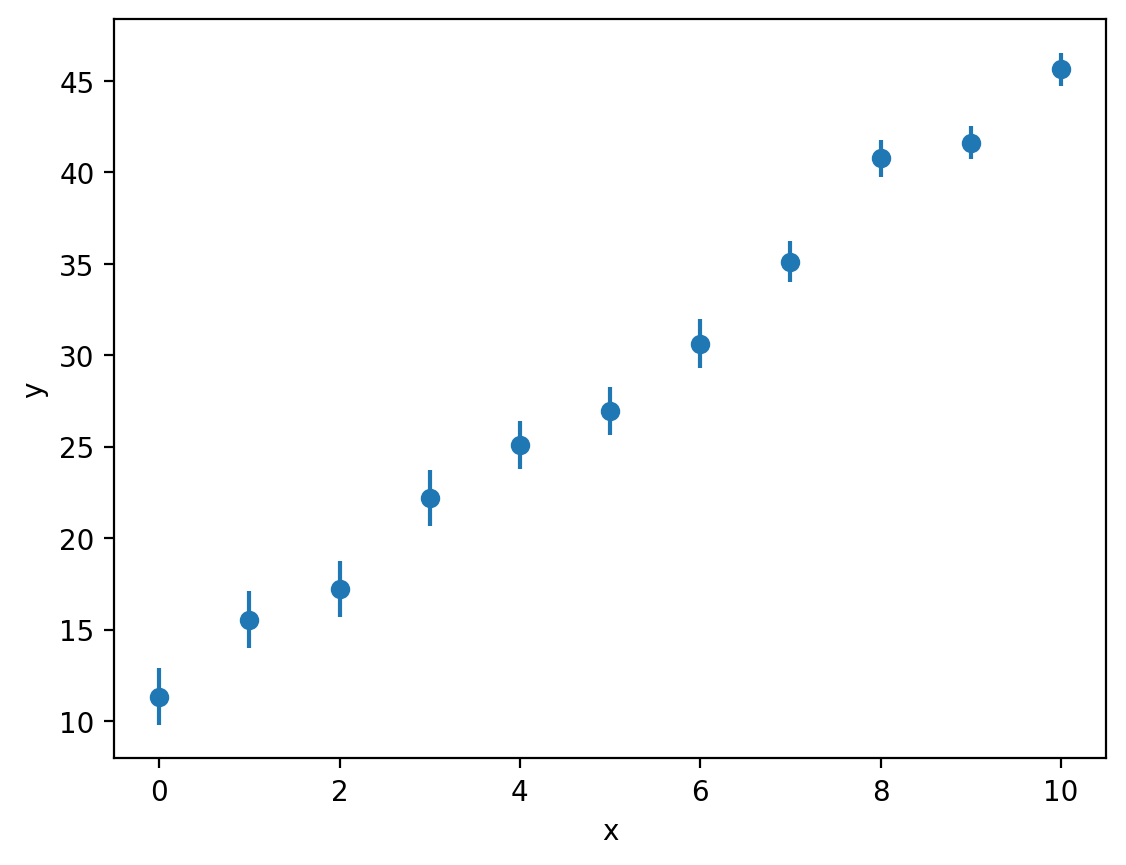

In [9]:
y_err = [1.55, 1.55, 1.53, 1.53, 1.33, 1.33, 1.33, 1.12, 1.02, 0.9, 0.9] # variance in each data point

plt.errorbar(x, y, y_err, fmt='o')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

As you can see above, we can plot error bars using `plt.errorbar`, passing the size of each error bar as a **third** argument (here passed as the variable `y_err`). The `fmt` keyword argument is used to prevent `matplotlib` from joining each point with a line (this is roughly equivalent how we can pass strings such as `'o'` or `'o-'` to the `plt.plot` function to change how the data is rendered).

To perform linear regression on this dataset that explicitly **accounts for the error bars**, we are going to use the `curve_fit` function:

In [10]:
from scipy.optimize import curve_fit

Given that we're trying to fit a **straight line**, you might be wondering why on earth we're using a function called **curve**_fit. Simply put, `curve_fit` is a much more robust general-use function than `linregress` (it is not limited to **linear** regression) and it has a keyword argument `sigma` that can be used to explicitly account for uncertainties in the experimental $y$-data using the [weighted least-squares](https://en.wikipedia.org/wiki/Weighted_least_squares) method.

As mentioned above, `curve_fit` is not limited to fitting straight lines (hence the `curve` in the name). As a result, we have to specify the **model** we would like to try to **fit** to our dataset. In this case, our data is linear, so the model we are going to try and fit is the equation of a straight line:

$$y = mx + c,$$

where $m$ is the slope and $c$ is the intercept. We can define this model in Python as a **function**:

In [11]:
def straight_line(x, m, c):
    """Calculate y = mx + c (the equation of a straight line).

    Args:
        x (np.ndarray): A numpy array containing all of the x-values.
        m (float): The slope of the line.
        c (float): The y-intercept of the line.

    Returns:
        np.ndarray: The y-values.
        
    """

    return m * x + c

We can now pass our function **as an argument** to `curve_fit`, also passing the experimental $x$ and $y$ data as well as the uncertainties using the `sigma` keyword argument:

In [12]:
regression_data = curve_fit(straight_line, x, y, sigma=y_err)

`curve_fit` **returns** a `tuple` of two elements:

In [13]:
regression_data

(array([ 3.45325015, 11.13753085]),
 array([[ 0.01099572, -0.06900366],
        [-0.06900366,  0.53969832]]))

The first of these is a `numpy` array containing the optimised parameters for our model in the order they are specified in the function definition. In this case, our `straight_line` function takes the arguments `x`, `m` and `c`:

```python
def straight_line(x, m, c):
```

`m` comes before `c`, so the same order will be reflected in the optimised parameters:

In [14]:
regression_data[0]

array([ 3.45325015, 11.13753085])

The second element of `regression_data` is the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix), again in the form of a `numpy` array:

In [15]:
regression_data[1]

array([[ 0.01099572, -0.06900366],
       [-0.06900366,  0.53969832]])

Without getting into the underlying statistics, the important data here is on the **diagonal** of this matrix. Again in the same order as specified in the function definition, each element on the diagonal is the **variance** associated with that parameter.

In [16]:
slope, intercept = regression_data[0]
covariance_matrix = regression_data[1]
slope_variance = covariance_matrix[0,0] # First element of the diagonal, row 1 column 1
intercept_variance = covariance_matrix[1,1] # Second element of the diagonal, row 2 column 2

print(f'm = {slope} +/- {np.sqrt(slope_variance)}')
print(f'c = {intercept} +/- {np.sqrt(intercept_variance)}')

m = 3.453250149391414 +/- 0.10486045719741142
c = 11.137530853332157 +/- 0.7346416248091884


Unlike when we used the `linregress` function, these errors actually account for the uncertainties in the experimental data. We take the square root here to get the **standard error** rather than the variance associated with each parameter. We can visualise our fitted model (our line of best fit) just like we did before:

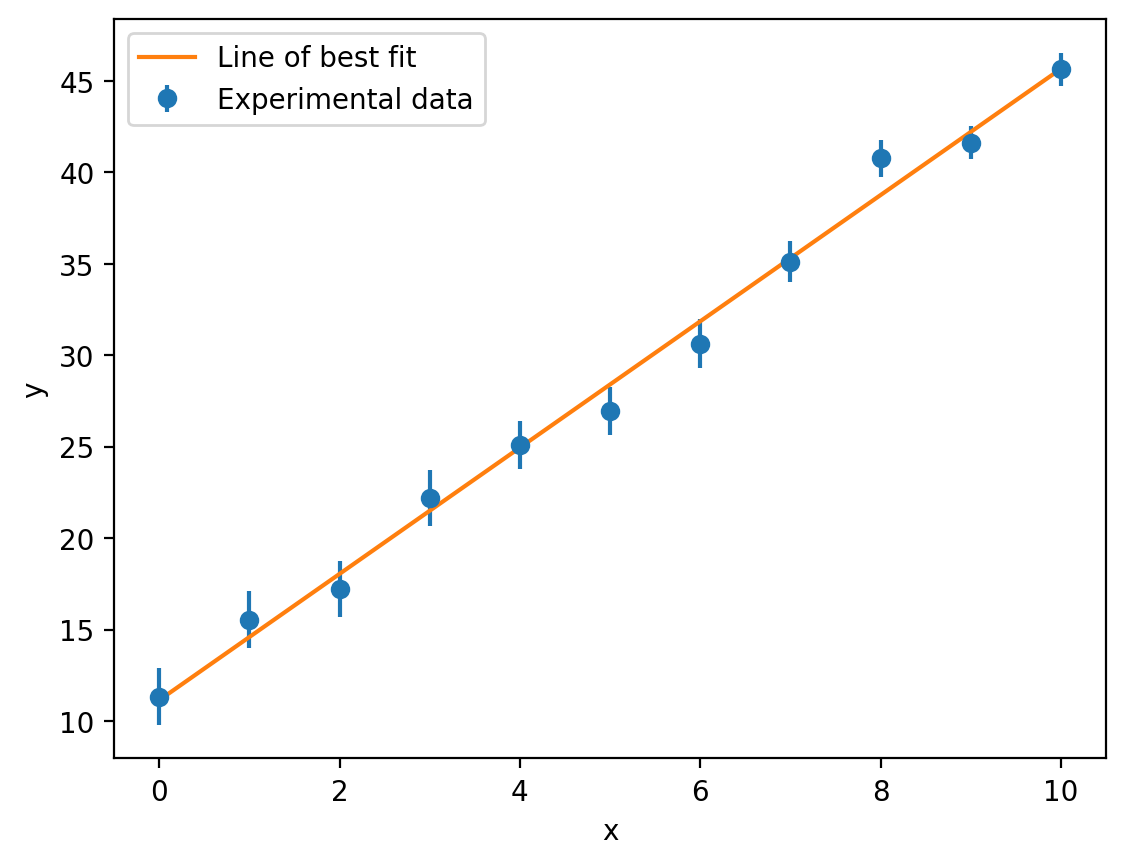

In [17]:
y_model = straight_line(x, slope, intercept) # y = mx + c

plt.errorbar(x, y, y_err, fmt='o', label='Experimental data')
plt.plot(x, y_model, label='Line of best fit')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.show()

In this case, our final plot (and our values of $m$ and $c$) are pretty similar whether we use the **ordinary** least-squares (`linregress`) or **weighted** least-squares (`curve_fit` with `sigma`) methods, but this is certainly not guaranteed to be the case and it is therefore **very important** to propagate experimental uncertanties through to our fitted model parameters when possible.